In [2]:
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np

# Calc FLOPS

In [3]:
from calc_pseudo import clean, basic_flops
B_TARGET_PANEL_WIDTH = 48

In [4]:
MAT_PATH = "./../../../example_mats_med/"
mat_paths = sum([[os.path.join(dir, file) for file in files] for dir, _, files in os.walk(MAT_PATH)], [])

In [5]:
mat_flops = {}

In [6]:
for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    
    mat_flops[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL

## Load Data

In [7]:
COMB_DIR = "./../../../logs/regpack_comb/pyfr/" # local=L1_N2_M3, ref=L1_N3_M2

LN3_DIR = "./../../../logs/regpack_macc/regpack_ln3/pyfr/"
LM3_DIR = "./../../../logs/regpack_macc/regpack_lm3/pyfr/"

RP_DIR  = "./../../../logs/reg_pack/pyfr/"
DENSE_DIR = "./../../../logs/reg_pack/pyfr/dense/"

In [8]:
comb_runs = []
rp_runs = []
dense_runs = []
ln3_runs = []
lm3_runs = []

In [9]:
NUM_RUNS = 3

for i in range(1,NUM_RUNS+1):
    with open(COMB_DIR+"run_{}.dat".format(i), "rb") as f:
        comb_runs.append( pickle.load(f) )
    with open(RP_DIR+"run_{}.dat".format(i), "rb") as f:
        rp_runs.append( pickle.load(f) )
    with open(DENSE_DIR+"run_{}.dat".format(i), "rb") as f:
        dense_runs.append( pickle.load(f) )
    with open(LN3_DIR+"run_{}.dat".format(i), "rb") as f:
        ln3_runs.append( pickle.load(f) )
    with open(LM3_DIR+"run_{}.dat".format(i), "rb") as f:
        lm3_runs.append( pickle.load(f) )

## Sort Data

In [10]:
def sort_values(x_term, run, mat_flops, t='best'):
    NUM_PANELS = 192000 / 48

    local_best = []
    ref_best = []
    local_best_x, local_best_y = [], []
    ref_best_x, ref_best_y = [], []

    for i, u in enumerate(run[x_term]):
        FLOPS_PER_PANEL = mat_flops[run['mat_file'][i]]

        time_per_panel_local = (run['xsmm_local_'+t][i]*1e-3)/NUM_PANELS
        time_per_panel_ref   = (run['xsmm_upstream_'+t][i]*1e-3)/NUM_PANELS
        
        local_best_x.append(u)
        local_best_y.append(FLOPS_PER_PANEL / time_per_panel_local)
        ref_best_x.append(u)
        ref_best_y.append(FLOPS_PER_PANEL / time_per_panel_ref)
    
    old_len = len(local_best_y)

    local_best_y = [x for _,x in sorted(zip(local_best_x,local_best_y))]
    local_best_x.sort()
    
    assert(old_len == len(local_best_y))

    ref_best_y = [x for _,x in sorted(zip(ref_best_x,ref_best_y))]
    ref_best_x.sort()

    return local_best_x, local_best_y, ref_best_x, ref_best_y

In [11]:
x_terms = ['a_unique', 'a_cols', 'a_rows', 'a_size', 'density']
xlabels = ['Number of Unique Constants', 'Number of Columns',
           'Number of Rows', 'Size', 'Density']
xtitles = ['Number of Unique Constants in A', 'Number of Columns in A',
           'Number of Rows in A', 'Size of A', 'Density of A']

In [12]:
def get_local_upstream_perf(runs, shape, x_term):
    global mat_flops
    local_best_x1, local_best_y1, ref_best_x1, ref_best_y1 = \
        sort_values(x_term, runs[0][shape], mat_flops, 'best')
    local_best_x2, local_best_y2, ref_best_x2, ref_best_y2 = \
        sort_values(x_term, runs[1][shape], mat_flops, 'best')
    local_best_x3, local_best_y3, ref_best_x3, ref_best_y3 = \
        sort_values(x_term, runs[2][shape], mat_flops, 'best')

    local_best_y_avg = [sum(elem)/len(elem) for elem in zip(local_best_y1, local_best_y2, local_best_y3)]
    ref_best_y_avg = [sum(elem)/len(elem) for elem in zip(ref_best_y1, ref_best_y2, ref_best_y3)]
    
    return local_best_x1, local_best_y_avg, ref_best_y_avg

## Quad

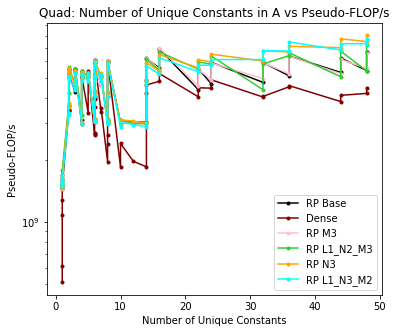

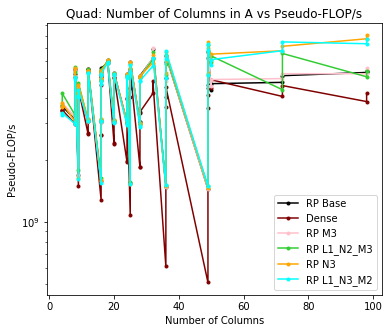

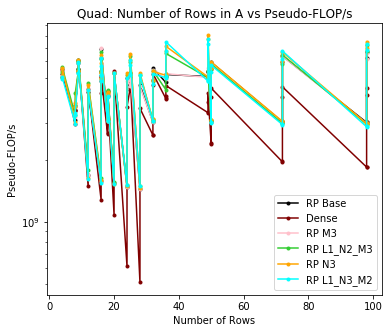

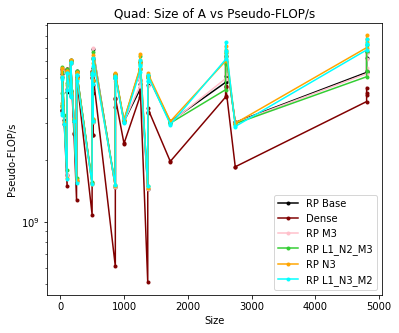

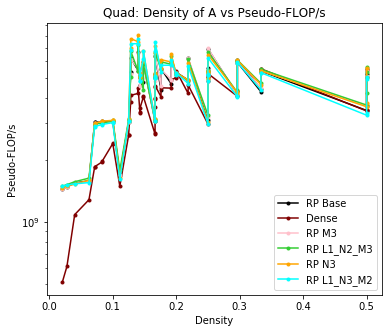

In [16]:
for i, x_term in enumerate(x_terms):
    plt.figure(figsize=(6,5))

    comb_xvals, l1_n2_m3_avg, l1_n3_m2_avg = get_local_upstream_perf(comb_runs, "quad", x_term)
    
    ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "quad", x_term)
    lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "quad", x_term)
        
    rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "quad", x_term)
    plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
    dense_xvals, _, dense_avg = get_local_upstream_perf(dense_runs, "quad", x_term)
    plt.plot(dense_xvals, dense_avg, label="Dense", color="maroon", marker=".")

    plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="pink", marker=".")
    plt.plot(comb_xvals, l1_n2_m3_avg, label="RP L1_N2_M3", color="limegreen", marker=".")
    plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")
    plt.plot(comb_xvals, l1_n3_m2_avg, label="RP L1_N3_M2", color="cyan", marker=".")

    plt.xlabel(xlabels[i])
    plt.ylabel("Pseudo-FLOP/s")
    plt.yscale("log", basey=10)
    plt.title("Quad: " + xtitles[i] + " vs Pseudo-FLOP/s")
    #plt.ylim(top=8e9)
    plt.legend()
    plt.savefig("./../../../plots/regpack_comb/pyfr/quad/"+x_term+".pdf")
    plt.show()

## Hex

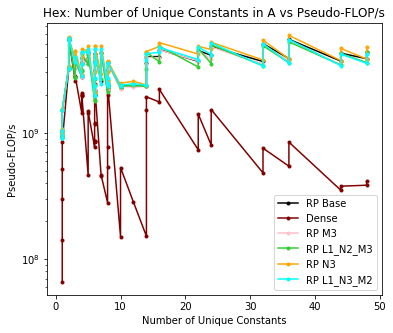

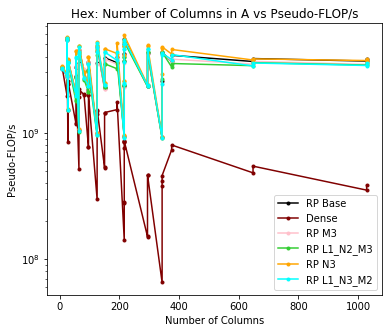

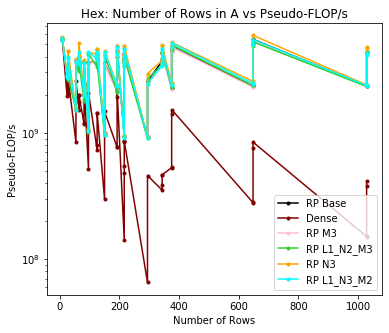

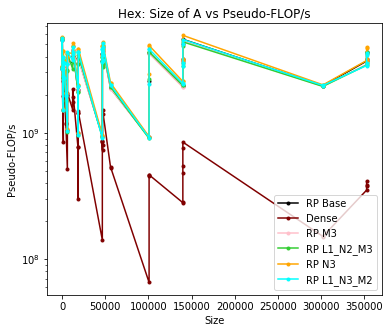

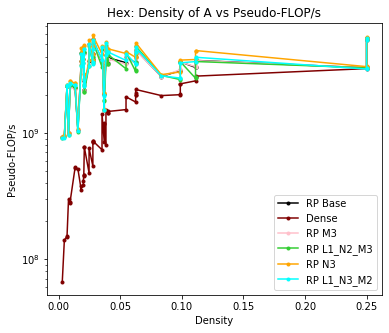

In [17]:
for i, x_term in enumerate(x_terms):
    plt.figure(figsize=(6,5))

    comb_xvals, l1_n2_m3_avg, l1_n3_m2_avg = get_local_upstream_perf(comb_runs, "hex", x_term)
    
    ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "hex", x_term)
    lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "hex", x_term)
        
    rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "hex", x_term)
    plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
    dense_xvals, _, dense_avg = get_local_upstream_perf(dense_runs, "hex", x_term)
    plt.plot(dense_xvals, dense_avg, label="Dense", color="maroon", marker=".")

    plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="pink", marker=".")
    plt.plot(comb_xvals, l1_n2_m3_avg, label="RP L1_N2_M3", color="limegreen", marker=".")
    plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")
    plt.plot(comb_xvals, l1_n3_m2_avg, label="RP L1_N3_M2", color="cyan", marker=".")

    plt.xlabel(xlabels[i])
    plt.ylabel("Pseudo-FLOP/s")
    plt.yscale("log", basey=10)
    plt.title("Hex: " + xtitles[i] + " vs Pseudo-FLOP/s")
    #plt.ylim(top=8e9)
    plt.legend()
    plt.savefig("./../../../plots/regpack_comb/pyfr/hex/"+x_term+".pdf")
    plt.show()

## Tet

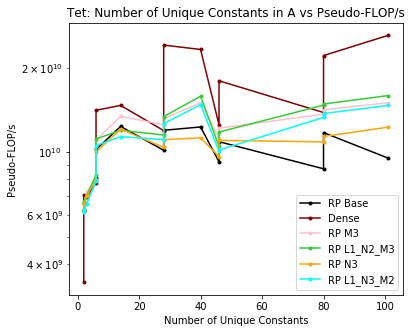

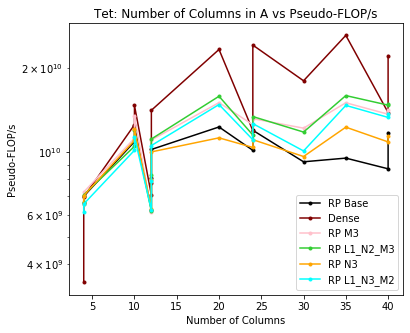

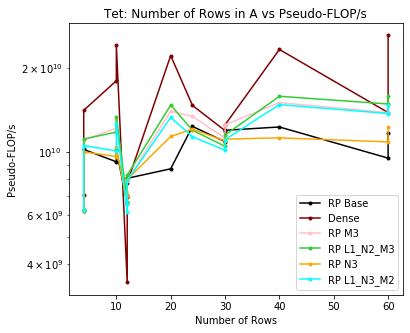

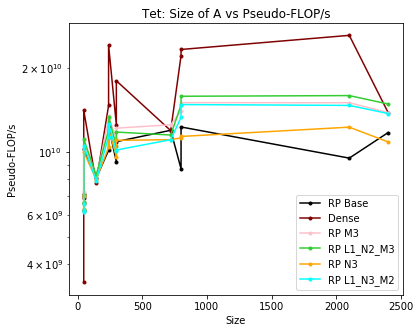

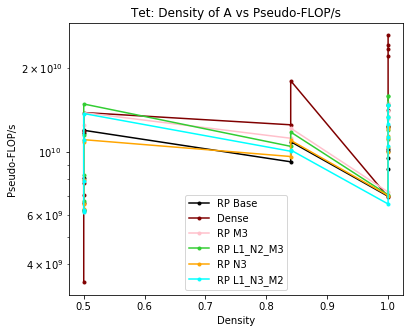

In [18]:
for i, x_term in enumerate(x_terms):
    plt.figure(figsize=(6,5))

    comb_xvals, l1_n2_m3_avg, l1_n3_m2_avg = get_local_upstream_perf(comb_runs, "tet", x_term)
    
    ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "tet", x_term)
    lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "tet", x_term)
        
    rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "tet", x_term)
    plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
    dense_xvals, _, dense_avg = get_local_upstream_perf(dense_runs, "tet", x_term)
    plt.plot(dense_xvals, dense_avg, label="Dense", color="maroon", marker=".")

    plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="pink", marker=".")
    plt.plot(comb_xvals, l1_n2_m3_avg, label="RP L1_N2_M3", color="limegreen", marker=".")
    plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")
    plt.plot(comb_xvals, l1_n3_m2_avg, label="RP L1_N3_M2", color="cyan", marker=".")

    plt.xlabel(xlabels[i])
    plt.ylabel("Pseudo-FLOP/s")
    plt.yscale("log", basey=10)
    plt.title("Tet: " + xtitles[i] + " vs Pseudo-FLOP/s")
    #plt.ylim(top=8e9)
    plt.legend()
    plt.savefig("./../../../plots/regpack_comb/pyfr/tet/"+x_term+".pdf")
    plt.show()

## Tri

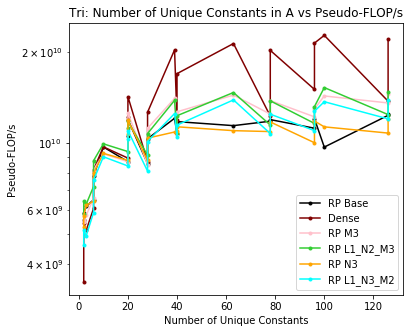

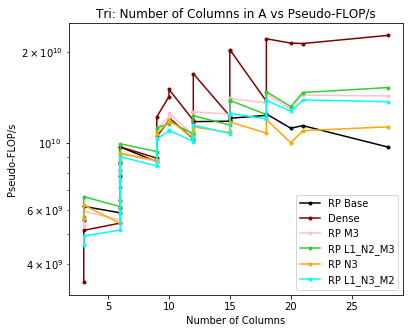

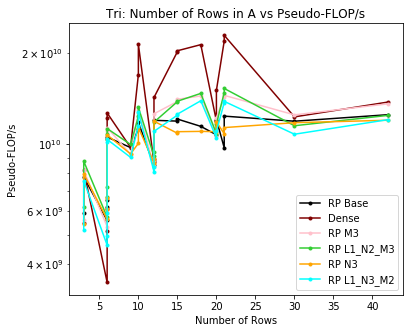

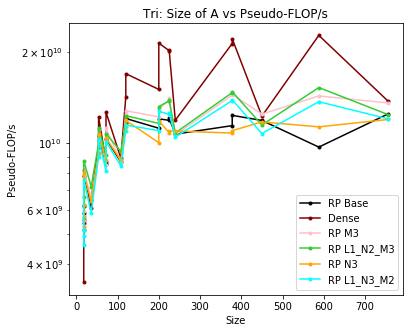

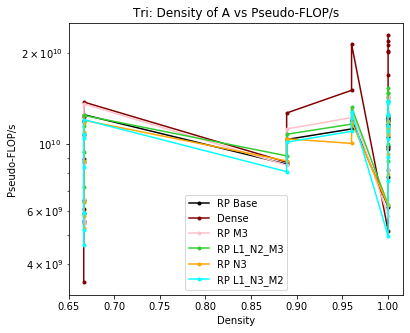

In [19]:
for i, x_term in enumerate(x_terms):
    plt.figure(figsize=(6,5))

    comb_xvals, l1_n2_m3_avg, l1_n3_m2_avg = get_local_upstream_perf(comb_runs, "tri", x_term)
    
    ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "tri", x_term)
    lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "tri", x_term)
        
    rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "tri", x_term)
    plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
    dense_xvals, _, dense_avg = get_local_upstream_perf(dense_runs, "tri", x_term)
    plt.plot(dense_xvals, dense_avg, label="Dense", color="maroon", marker=".")

    plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="pink", marker=".")
    plt.plot(comb_xvals, l1_n2_m3_avg, label="RP L1_N2_M3", color="limegreen", marker=".")
    plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")
    plt.plot(comb_xvals, l1_n3_m2_avg, label="RP L1_N3_M2", color="cyan", marker=".")

    plt.xlabel(xlabels[i])
    plt.ylabel("Pseudo-FLOP/s")
    plt.yscale("log", basey=10)
    plt.title("Tri: " + xtitles[i] + " vs Pseudo-FLOP/s")
    #plt.ylim(top=8e9)
    plt.legend()
    plt.savefig("./../../../plots/regpack_comb/pyfr/tri/"+x_term+".pdf")
    plt.show()